# Predictions using the location informations and the prices.

## Load CSV files

In [2]:
import pandas as pd

# Load the two CSV files into dataframes
coworking_info_df = pd.read_csv('/workspaces/Coworking/src/results/updated_location_coworking.csv')
prices_df = pd.read_csv('/workspaces/Coworking/src/results/PreciosCoworking.csv')

# Display the first few rows to confirm the data is loaded correctly
print(coworking_info_df.head())
print(prices_df.head())


                     Unnamed: 0 Neightboorhood  Population  \
0  Coworking Area - Plaza Río 2       Delicias      28.575   
1          Talent Garden Madrid        Adelfas      18.832   
2                      Freeland         Cortes   10816.000   
3        Coworking LOOM Huertas         Opañel   33883.000   
4             EslabON Coworking       Delicias      28.575   

  Percentage of population between 16 and 64 years ForeignPopulation  \
0                                            69,3%            13.00%   
1                                           64,6 %             8,6 %   
2                                            76,4%             28,4%   
3                                            68,7%            25.00%   
4                                            69,3%            13.00%   

   Unemployes  Household average net rent  Metro Closest bus stop  \
0         962                       45392      6             900m   
1         591                       50837      5        

## Merge the dataframes.

In [3]:
# Check the columns of both dataframes
print(coworking_info_df.columns)
print(prices_df.columns)


Index(['Unnamed: 0', 'Neightboorhood', 'Population',
       'Percentage of population between 16 and 64 years', 'ForeignPopulation',
       'Unemployes', 'Household average net rent', 'Metro', 'Closest bus stop',
       'formatted_address', 'lat', 'lng'],
      dtype='object')
Index(['Unnamed: 0', 'EslabOn', 'Area', 'Freeland', 'Talent Garden', 'Loom'], dtype='object')


In [4]:
# Rename the 'Unnamed: 0' column to 'Coworking Area' in coworking_info_df
coworking_info_df.rename(columns={'Unnamed: 0': 'Coworking Area'}, inplace=True)

In [5]:
# Transpose the prices dataframe to make the coworking areas as rows
prices_df_transposed = prices_df.transpose()

# Reset index and rename the columns appropriately
prices_df_transposed.reset_index(inplace=True)
prices_df_transposed.columns = ['Coworking Area', 'Mesa Fija', 'Mesa Flexible', 'Despacho Priado', 'Pases/Bonos (días)']


In [6]:
# Merge the two dataframes on 'Coworking Area'
merged_df = pd.merge(coworking_info_df, prices_df_transposed, how='inner', on='Coworking Area')

# Display the merged dataframe
print(merged_df.head())


  Coworking Area Neightboorhood  Population  \
0       Freeland         Cortes     10816.0   

  Percentage of population between 16 and 64 years ForeignPopulation  \
0                                            76,4%             28,4%   

   Unemployes  Household average net rent  Metro Closest bus stop  \
0         438                       40008     10             110m   

                                   formatted_address        lat       lng  \
0  C. de Gandía, 1, local 9A, Retiro, 28007 Madri...  40.398585 -3.671745   

  Mesa Fija Mesa Flexible Despacho Priado Pases/Bonos (días)  
0       150            95             375                 20  


## Data Processing.

In [7]:
# Clean the percentage columns by replacing commas with dots and removing the '%' symbol
merged_df['Percentage of population between 16 and 64 years'] = merged_df['Percentage of population between 16 and 64 years'] \
    .str.replace(',', '.', regex=False) \
    .str.replace('%', '', regex=False) \
    .astype(float) / 100

# Clean the 'ForeignPopulation' column (if necessary)
merged_df['ForeignPopulation'] = merged_df['ForeignPopulation'] \
    .str.replace(',', '.', regex=False) \
    .str.replace('%', '', regex=False) \
    .astype(float) / 100


In [8]:
print(merged_df[['Percentage of population between 16 and 64 years', 'ForeignPopulation']].head())

   Percentage of population between 16 and 64 years  ForeignPopulation
0                                             0.764              0.284


## Visualizations.

### Heatmap

In [9]:
from sklearn.preprocessing import MinMaxScaler

# Normalize the columns that have values in different scales
columns_to_normalize = ['Population', 'Household average net rent', 
                        'Percentage of population between 16 and 64 years', 'ForeignPopulation']
scaler = MinMaxScaler()

# Apply normalization
merged_df[columns_to_normalize] = scaler.fit_transform(merged_df[columns_to_normalize])

# Now calculate the correlation matrix
corr = merged_df[columns_to_normalize].corr()

print(corr)

                                                  Population  \
Population                                               NaN   
Household average net rent                               NaN   
Percentage of population between 16 and 64 years         NaN   
ForeignPopulation                                        NaN   

                                                  Household average net rent  \
Population                                                               NaN   
Household average net rent                                               NaN   
Percentage of population between 16 and 64 years                         NaN   
ForeignPopulation                                                        NaN   

                                                  Percentage of population between 16 and 64 years  \
Population                                                                                     NaN   
Household average net rent                                                

In [10]:
price_columns = ['Mesa Fija', 'Mesa Flexible', 'Despacho Priado', 'Pases/Bonos (días)']
merged_df[price_columns] = scaler.fit_transform(merged_df[price_columns])


In [13]:
corr = merged_df[price_columns].corr

print(corr)

<bound method DataFrame.corr of    Mesa Fija  Mesa Flexible  Despacho Priado  Pases/Bonos (días)
0        0.0            0.0              0.0                 0.0>


/workspaces/Coworking/new_venv/lib/python3.12/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/workspaces/Coworking/new_venv/lib/python3.12/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


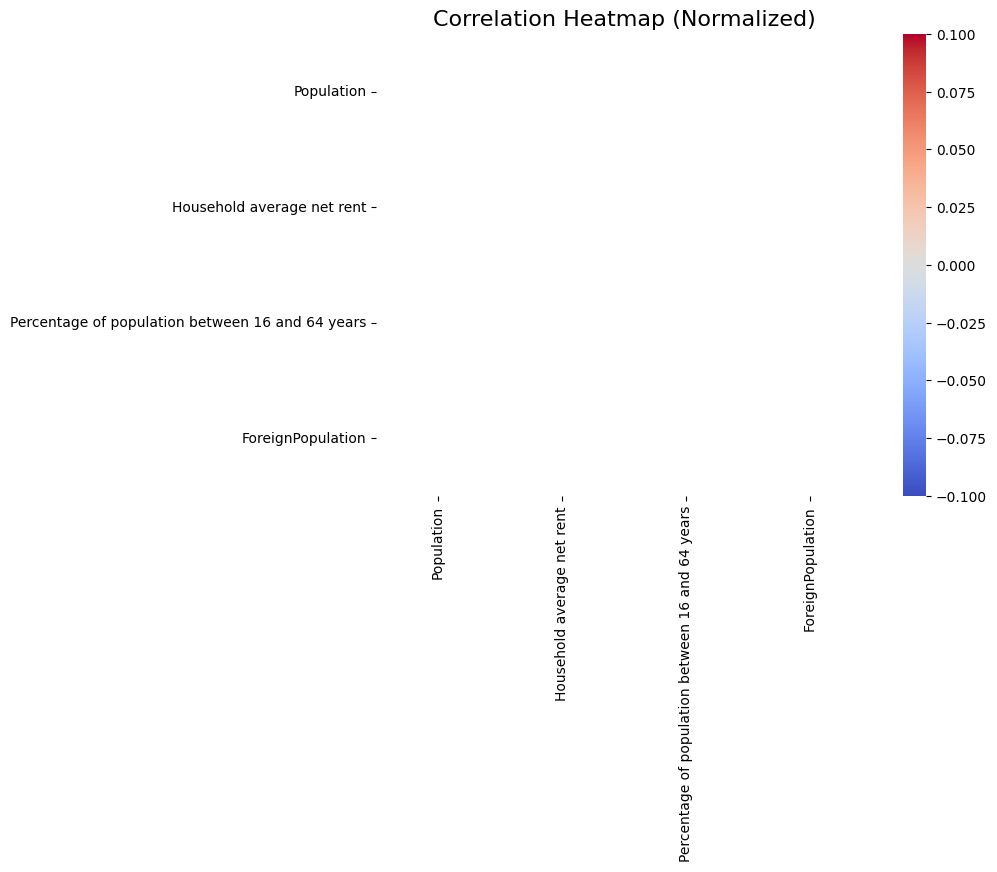

In [11]:
# Create the heatmap
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap (Normalized)', fontsize=16)
plt.show()

### Radar Chart.

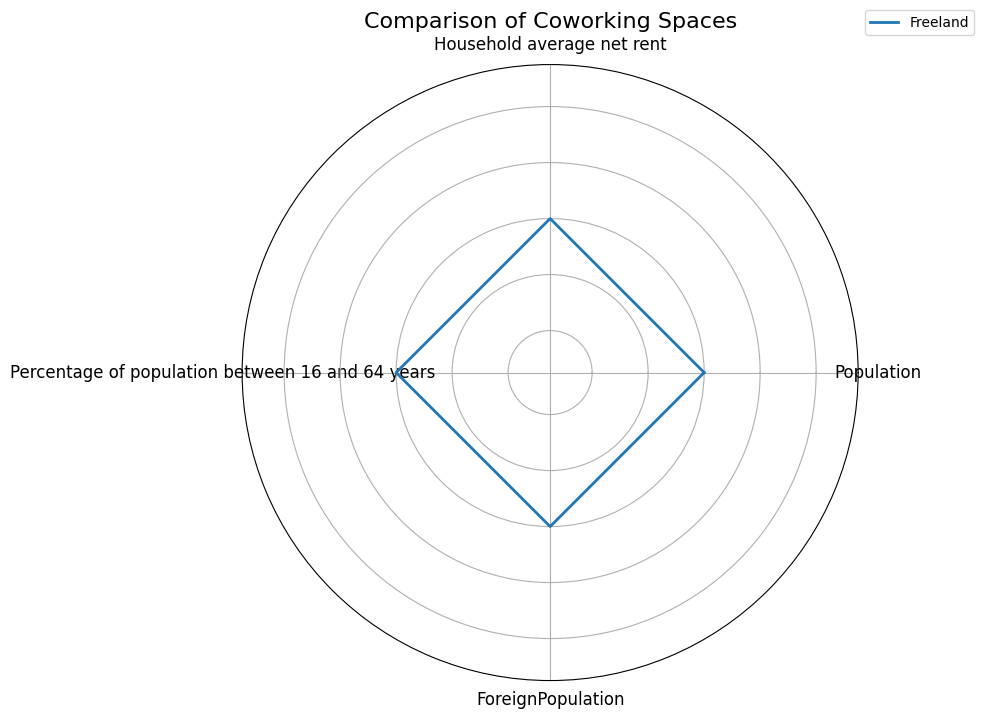

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# We will select the columns we want to compare (e.g., Population, Rent, etc.)
features = ['Population', 'Household average net rent', 'Percentage of population between 16 and 64 years', 'ForeignPopulation']

# Extract data for radar chart
data = merged_df[features].T  # Transpose to have each coworking space as a column
data.columns = merged_df['Coworking Area']  # Set coworking names as column names

# Create a radar chart
angles = np.linspace(0, 2 * np.pi, len(features), endpoint=False).tolist()
angles += angles[:1]  # Close the loop

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
for coworking in data.columns:
    values = data[coworking].tolist()
    values += values[:1]  # Close the loop
    ax.plot(angles, values, linewidth=2, linestyle='solid', label=coworking)

ax.set_yticklabels([])  # Hide the radial axis labels
ax.set_xticks(angles[:-1])
ax.set_xticklabels(features, fontsize=12)
ax.set_title('Comparison of Coworking Spaces', fontsize=16)
ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.1))

plt.show()
